# 1. Data Exploration and Preprocessing

**Student:** Student 1

## Purpose
- Load and explore the dataset
- Analyze dataset statistics and class distribution
- Implement preprocessing pipeline (normalization, resizing)
- Create train/validation/test splits with stratification
- Visualize sample images and augmentations

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from torchvision import transforms

# reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")


Imports loaded successfully.


In [2]:
# Load dataset from Data/archive
DATA_DIR = "../Data/archive"

# Load CSVs
train_df = pd.read_csv(f"{DATA_DIR}/fashion-mnist_train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/fashion-mnist_test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Labels are in the first column
num_classes = train_df['label'].nunique()
print("Number of classes:", num_classes)
print("Classes:", sorted(train_df['label'].unique()))

# Convert one row into an image for demonstration
sample_row = train_df.iloc[0, 1:].values.astype(np.uint8)   # 784 pixels
sample_img = sample_row.reshape(28, 28)

print("Image shape (H,W):", sample_img.shape)

# Convert to PIL to match torchvision expectations
pil_sample = Image.fromarray(sample_img, mode='L')
display(pil_sample)


Train shape: (60000, 785)
Test shape: (10000, 785)
Number of classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Image shape (H,W): (28, 28)


/Users/michaellukyanov/PycharmProjects/deep_learning_project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaellukyanov/PycharmProjects/deep_learning_project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaellukyanov/PycharmProjects/deep_learning_project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


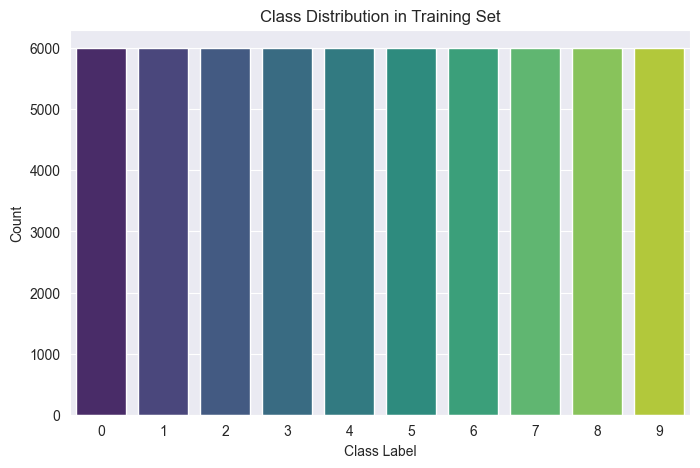

Class counts:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Is dataset imbalanced? No


In [3]:
# Analyze class distribution

plt.figure(figsize=(8, 5))
sns.countplot(x=train_df["label"], palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

class_counts = train_df["label"].value_counts().sort_index()
print("Class counts:\n", class_counts)
print("\nIs dataset imbalanced?", "Yes" if class_counts.max() / class_counts.min() > 1.5 else "No")


In [4]:
# Check for exact duplicate images in the dataset
# Duplicates are defined as identical pixel vectors (784 values)

# Separate labels and image data
labels = train_df["label"].values
images = train_df.iloc[:, 1:].values  # shape: (60000, 784)

# Convert each image to a hashable representation
image_bytes = [img.tobytes() for img in images]

# Build a DataFrame for duplicate analysis
dup_df = pd.DataFrame({
    "label": labels,
    "image_bytes": image_bytes
})

# ---- Global duplicates (ignoring class) ----
global_duplicate_mask = dup_df.duplicated(subset="image_bytes", keep=False)
num_global_duplicates = global_duplicate_mask.sum()

print("Total samples:", len(train_df))
print("Total duplicate samples (global):", num_global_duplicates)
print("Unique images:", len(train_df) - num_global_duplicates)

# ---- Duplicates within the same class ----
within_class_duplicate_mask = dup_df.duplicated(
    subset=["label", "image_bytes"], keep=False
)
num_within_class_duplicates = within_class_duplicate_mask.sum()

print("\nDuplicate samples within the same class:", num_within_class_duplicates)

# ---- Optional: duplicates per class ----
duplicates_per_class = (
    dup_df[within_class_duplicate_mask]
    .groupby("label")
    .size()
)

print("\nDuplicates per class (within-class):")
print(duplicates_per_class if not duplicates_per_class.empty else "None")


Total samples: 60000
Total duplicate samples (global): 86
Unique images: 59914

Duplicate samples within the same class: 86

Duplicates per class (within-class):
label
0     4
1     8
2    24
3     6
4    10
6    22
7     8
9     4
dtype: int64


In [5]:
# Remove exact duplicate images within the same class
# Keep the first occurrence of each (label, image)

initial_size = len(train_df)

train_df_dedup = train_df.drop_duplicates(
    subset=["label"] + list(train_df.columns[1:]),
    keep="first"
).reset_index(drop=True)

final_size = len(train_df_dedup)

print("Initial training samples:", initial_size)
print("Final training samples after deduplication:", final_size)
print("Removed samples:", initial_size - final_size)

# Verify no duplicates remain
images_dedup = train_df_dedup.iloc[:, 1:].values
labels_dedup = train_df_dedup["label"].values

dup_check = pd.DataFrame({
    "label": labels_dedup,
    "image_bytes": [img.tobytes() for img in images_dedup]
})

remaining_dups = dup_check.duplicated(
    subset=["label", "image_bytes"], keep=False
).sum()

print("Remaining duplicates (within-class):", remaining_dups)


Initial training samples: 60000
Final training samples after deduplication: 59957
Removed samples: 43
Remaining duplicates (within-class): 0


In [7]:
# Class counts before and after deduplication

counts_before = train_df["label"].value_counts().sort_index()
counts_after = train_df_dedup["label"].value_counts().sort_index()

comparison_df = pd.DataFrame({
    "Before": counts_before,
    "After": counts_after,
})

comparison_df["Removed"] = comparison_df["Before"] - comparison_df["After"]
comparison_df["Removed (%)"] = (
    comparison_df["Removed"] / comparison_df["Before"] * 100
).round(3)

print("Class distribution before vs. after deduplication:\n")
print(comparison_df)


Class distribution before vs. after deduplication:

       Before  After  Removed  Removed (%)
label                                     
0        6000   5998        2        0.033
1        6000   5996        4        0.067
2        6000   5988       12        0.200
3        6000   5997        3        0.050
4        6000   5995        5        0.083
5        6000   6000        0        0.000
6        6000   5989       11        0.183
7        6000   5996        4        0.067
8        6000   6000        0        0.000
9        6000   5998        2        0.033


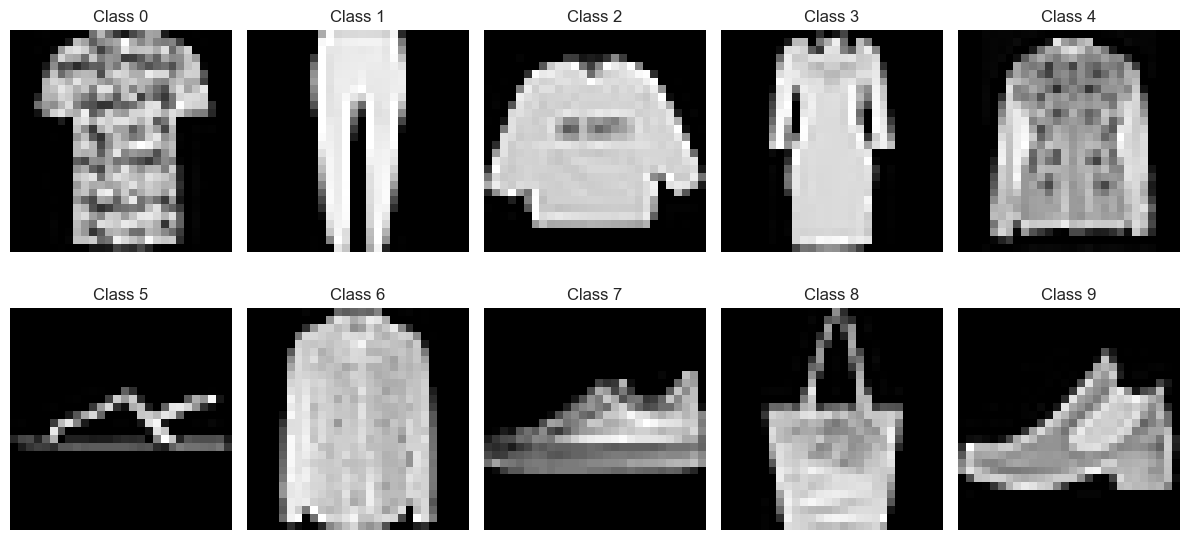

In [8]:
# Visualize sample images from each class

unique_labels = sorted(train_df["label"].unique())
num_classes = len(unique_labels)

plt.figure(figsize=(12, 6))

for idx, label in enumerate(unique_labels):
    # Find first row belonging to the label
    row = train_df[train_df["label"] == label].iloc[0, 1:]
    img = row.values.astype(np.uint8).reshape(28, 28)

    plt.subplot(2, num_classes // 2, idx + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Class {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Implement preprocessing pipeline

# ---- Preprocessing pipeline for pretrained models ----
preprocess_transform = transforms.Compose([
    # raw numpy array → PIL image
    transforms.ToPILImage(),
    # convert 1-channel grayscale → 3-channel RGB
    transforms.Grayscale(num_output_channels=3),
    # resize to ImageNet pretrained model size
    transforms.Resize((224, 224)),
    # convert to PyTorch tensor in [0,1]
    transforms.ToTensor(),
    # Normalize using ImageNet statistics to match pretrained backbone expectations
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("Preprocessing pipeline created successfully.")

Preprocessing pipeline created successfully.


In [12]:
# 85 / 15 train / validation split
train_df_split, val_df = train_test_split(
    train_df_dedup,
    test_size=0.15,
    stratify=train_df_dedup["label"],
    random_state=42
)

print("Train samples:", len(train_df_split))
print("Validation samples:", len(val_df))
print("Official test samples:", len(test_df))

Train samples: 50963
Validation samples: 8994
Official test samples: 10000


In [13]:
# Implement custom Dataset class

class FashionMNISTCSV(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx].values.astype(np.uint8)

        label = int(row[0])
        img = row[1:].reshape(28, 28)  # original resolution

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0

        return img, label


In [14]:
# Create DataLoaders for train/validation/test

batch_size = 64

train_dataset = FashionMNISTCSV(train_df_split, transform=preprocess_transform)
val_dataset = FashionMNISTCSV(val_df, transform=preprocess_transform)
test_dataset = FashionMNISTCSV(test_df, transform=preprocess_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("Dataloaders created.")


Dataloaders created.


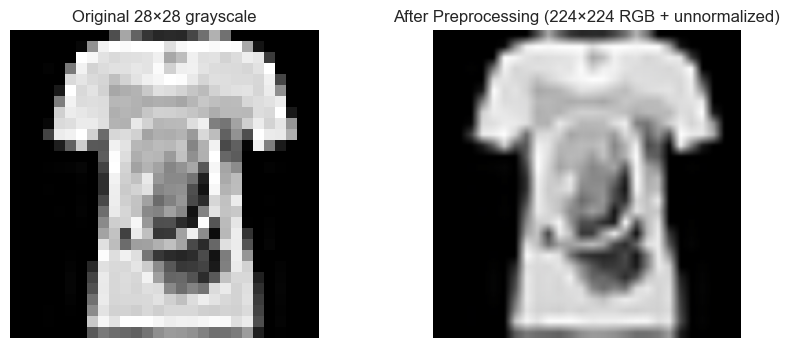

In [16]:
#  Visualize preprocessing pipeline: show before/after normalization
sample_row = train_df_split.iloc[0, 1:].values.astype(np.uint8)
original_img = sample_row.reshape(28, 28)

# Apply preprocessing
processed_img = preprocess_transform(original_img)

# Convert C×H×W → H×W×C for matplotlib
processed_img_np = processed_img.permute(1, 2, 0).numpy()

# Un-normalize for visualization using ImageNet stats
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
processed_img_np = processed_img_np * imagenet_std + imagenet_mean
processed_img_np = np.clip(processed_img_np, 0, 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original 28×28 grayscale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(processed_img_np)
plt.title("After Preprocessing (224×224 RGB + unnormalized)")
plt.axis("off")

plt.show()